# Preliminary run on barcoded pol mutant lentivirus

Allie Stanton

Data is from a MiSeq run with 250k reads started on March 13, 2019. The input material was from 293Ts transfected with approximately 0.02 MOI of lentivirus with a 15N barcode (plasmid 2626) and different single AA polymerase mutants.

## Reading in files

First I'll create a dictionary with the sample names (mutants) as keys and read 1 and read 2 file names as values. Then I'll define the functions that read in the data. I'll use the A272S sample as an example to go through each of the functions once and demonstrate their purpose before processing all of the samples.

In [1]:
from Bio import SeqIO
import itertools
import os
import random
import matplotlib.pyplot as plt
import numpy as np

files = {}
seqdir = os.path.join(os.getcwd(), "sequences")
for directory in os.listdir(seqdir):
    if not directory.startswith(".") and not directory.startswith("GFP"):
        longdir = os.path.join(seqdir, directory)
        for file in os.listdir(longdir):
            filename = os.fsdecode(file)
            if file.endswith("R1_001.fastq"):
                read1_file = os.path.join(longdir, filename)
            elif file.endswith("R2_001.fastq"):
                read2_file = os.path.join(longdir, filename)
        files[directory] = (read1_file, read2_file)

In [2]:
def read1_in(file):
######################################################################################
#                                                                                    #
# Reads in the read 1 sequence data and stores sequence and barcode data separately. #    
#                                                                                    #
# Inputs:                                                                            #
#      file: full path of file where read 1 data is stored in fastq format.          #
# Outputs:                                                                           #
#      barcodes: dictionary with record ids as keys and a string containing the 15N  #
#        barcode as values.                                                          #          
#      read1_seqs: dictionary with record ids as keys and a string containing the    #
#        first 100 bases of the corresponding read 1 after the barcode as values.    #
#                                                                                    #
######################################################################################

    barcodes = {}
    read1_seqs = {}
    for record in SeqIO.parse(file, "fastq"):
        # Make sure the adapter is present and sequence is correct length
        if str(record.seq[7:22]) == 'CTGTTTTAAGGATCC' and len(str(record.seq)) >= 149:
            bc = record.seq[22:37]
            barcodes[record.id] = str(bc)
            
            q_scores = record.letter_annotations["phred_quality"]
            q_scores_read = q_scores[37:149]
            read = list(str(record.seq[37:149]))

            read_qfilter = ''
            n_count = 0
            for i in range(len(read)):
                if q_scores_read[i] < 30:
                    read_qfilter += 'N'
                    n_count += 1
                else:
                    read_qfilter += read[i]
            
            if n_count <= 10:
                read1_seqs[record.id] = read_qfilter
    
    return barcodes, read1_seqs

In [3]:
A272S_files = files['A272S']
A272S_barcodes, A272S_read1_seqs = read1_in(A272S_files[0])
print(len(A272S_read1_seqs), "valid read 1 reads")

23671 valid read 1 reads


In [4]:
def read2_in(file):
######################################################################################
#                                                                                    #
# Reads in the read 2 sequence data and stores sequence and barcode data separately. #    
#                                                                                    #
# Inputs:                                                                            #
#      file: full path of file where read 2 data is stored in fastq format.          #
# Outputs:                                                                           #
#      read2_seqs: dictionary with record ids as keys and a string containing the    #
#        first 100 bases of the corresponding read 2 as values.                      #
#                                                                                    #
######################################################################################

    read2_seqs = {}
    for record in SeqIO.parse(file, "fastq"):
        # Make sure the adapter is present and sequence is the correct length
        if str(record.seq[3:14]) == 'CGGCGGCCGCC' and len(str(record.seq)) >= 149:
            q_scores = record.letter_annotations["phred_quality"]
            q_scores_read = q_scores[14:149]
            
            read = list(str(record.seq[14:149]))
            
            read_qfilter = ''
            n_count = 0
            for i in range(len(read)):
                if q_scores_read[i] < 30:
                    read_qfilter += 'N'
                    n_count += 1
                else:
                    read_qfilter += read[i]
            
            if n_count <= 10:
                read2_seqs[record.id] = read_qfilter
    
    return read2_seqs

In [5]:
A272S_read2_seqs = read2_in(A272S_files[1])
print(len(A272S_read2_seqs), "valid read 2 reads")

19550 valid read 2 reads


## Grouping read pairs into unique infection events by barcode
Each half of the read pairs is now associated with a unique record id that corresponds to a single molecule. Moreover, each barcode is now associated with one or more record ids. Most barcodes probably have more than one read pair associated with them as the DNA molecules from each infection are amplified by PCR. We now want to take each unique barcode and, using the record id as an intermediate, find all of the read pairs that are associated with that barcode and group them together. Meanwhile, since we filtered out some reads in the previous step that had adaptor or length issues, we want to make sure that we only keep read pairs where both halves of the pair exist. 

First we want to focus on just all unique barcodes and make groups of reads associated with identical barcodes, which should correspond to one integration associated with one infection event (more on this assumption later). Then we will collapse these groups if the barcodes are very similar. Finally, we will (somewhat heuristically) remove any abnormally large or small groups.

In [6]:
def find_barcode_groups(barcodes, read1_seqs, read2_seqs):
######################################################################################
#                                                                                    #
# Groups together read pairs that have the same barcode.                             #    
#                                                                                    #
# Inputs:                                                                            #
#      barcodes: dictionary with record ids as keys and a string containing the 15N  #
#        barcode as values.                                                          #  
#      read1_seqs: dictionary with record ids as keys and a string containing the    #
#        first 100 bases of the corresponding read 1 after the barcode as values.    #
#      read2_seqs: dictionary with record ids as keys and a string containing the    #
#        first 100 bases of the corresponding read 2 as values.                      #
# Outputs:                                                                           #
#      barcode_groups: dictionary with 15N barcode (type: str) as keys and           #
#        corresponding read pairs (type: tuple of strings) as values. Each key may   #
#        have multiple values.                                                       #
#      unique_valid: list of unique barcodes (list of strings).                      #
#                                                                                    #
######################################################################################

    # intersect the record ids to find record ids that have both read 1 and read 2
    shared_ids = list(read1_seqs.keys() & read2_seqs.keys())

    barcode_groups = {}
    for idx in shared_ids:
        readpair = (read1_seqs[idx], read2_seqs[idx])
        bc = barcodes[idx]
        
        # create a new sublist for each unique barcode and fill it with read pair tuple
        barcode_groups[bc] = barcode_groups.get(bc, [])
        barcode_groups[bc].append(readpair)
    
    # get a list of unique barcodes
    unique_valid = list(barcode_groups.keys())
    
    return barcode_groups, unique_valid

In [7]:
A272S_barcode_groups, A272S_unique_valid = find_barcode_groups(A272S_barcodes, A272S_read1_seqs, A272S_read2_seqs)
print(len(A272S_barcode_groups), "groups of valid read pairs where each group has a unique barcode")

3600 groups of valid read pairs where each group has a unique barcode


### Hamming distance
Hamming distance is a measure of the difference between two strings of equal length. It is equal to the number of positions at which the corresponding symbols are different. In this implementation, we calculate the Hamming distance by counting the number of unequal positions between the two strings. An example Hamming distance is given between two barcodes drawn from the A272S sample.

In [8]:
def hamming(s1, s2):
######################################################################################
#                                                                                    #
# Takes two sequences and computes the Hamming distance between them.                #  
#                                                                                    #
# Inputs:                                                                            #
#      s1, s2: two DNA sequences of equal length                                     #
# Outputs:                                                                           #
#      dist: an integer representing the hamming distance                            #
#                                                                                    #
######################################################################################
    
    if isinstance(s1, str) == 0:
        s1 = str(s1)
    if isinstance(s2, str) == 0:
        s2 = str(s2)
    
    s1 = list(s1)
    s2 = list(s2)

    dist = len([i for i, j in zip(s1, s2) if i != j and i != 'N' and j != 'N'])
    
    return dist

In [9]:
print(A272S_unique_valid[0])
print(A272S_unique_valid[1])
print("Hamming distance:", hamming(A272S_unique_valid[0], A272S_unique_valid[1]))

CAGTGCGGGGTGAGG
GTGGCCTTGGGGCAC
Hamming distance: 10


### Probabilistic interlude #1
We are about to use the Hamming distance metric to collapse barcode groups where the barcodes are very similar—specifically, when the distance between two barcodes is one. The motivation for this is that it seems relatively rare that two random 15mers would be so close as to differ by only one base, and PCR errors may be responsible for modifying barcodes that in fact originated from the same infection event.

But how likely exactly is it that without errors, no pair of (presumably) random barcodes in a group of several thousand barcodes are exactly one base apart? Well, we can easily find this mathematically: given an equal probability of mutation from or to any base, the probability that two given random 15mers differ by exactly one base is 

$15\times 0.25^{14}\times 0.75 = 4.191\times 10^{-8}$

Extend this to 3927 barcodes (the number of unique barcodes in the A272S sample) and the probability of having all barcodes be at least 2 bases apart from all other barcodes is

$(1 - (15\times (0.25^{14}\times 0.75))^{3927} = 0.9998$

It therefore seems safe to assume any barcodes that are 1 base apart are a result of PCR errors and did not truly originate from different events.

Note that in the above hamming_collapse function, I collapsed the barcodes into groups of a particular geometry. By this I mean that if a group is depicted as a graph where barcodes are nodes and edges exist where two nodes are at a Hamming distance of one, the graph has the following properties: 

1. Each node shares an edge with at least one other node

2. Every pair of nodes has a path between them (the graph is connected)

3. Each pair of nodes does not necessarily have an edge between them (the graph is not necessarily complete)

In other words, if a group contains barcodes A, B, and C, A and B may be different by one base and B and C may be different by one base, but A and C can be different by either one or two bases. This can theoretically result in an arbitrarily long chain of barcodes. I chose to ignore this (instead removing large groups at the end) as I couldnt come up with a better solution. 


In [10]:
def hamming_collapse(unique_valid): 
######################################################################################
#                                                                                    #
# Collapses barcodes into groups where barcodes within the group differ by one base  #
#   (Hamming distance of 1) and removes groups that contain more than 3 barcodes to  #
#   remove abnormally complex groups.                                                #
#                                                                                    #
# Inputs:                                                                            #
#      unique_valid: list of unique barcodes (list of strings).                      #
# Outputs:                                                                           #
#      hamm1_reduced: list of sublists where each sublist contains all of the tuples #
#        of read 1 and read 2 pairs that belong in one barcode group. If the barcode #
#        group has more than one barcode, the sublist will contain as many lists as  #
#        barcodes in the group.                                                      #
#                                                                                    #
######################################################################################

    unique_hamm1 = dict((k, 0) for k in unique_valid)
    unique_hamm1[unique_valid[0]] = 1

    counter = 0
    for i in unique_valid:
        counter += 1
        if unique_hamm1[i] == 0:
            unique_hamm1[i] = max(unique_hamm1.values()) + 1
        for j in unique_valid[counter: ]:
            if hamming(i, j) <= 1:
                unique_hamm1[j] = unique_hamm1[i]

    hamm1_groups = {}
    for k, v in unique_hamm1.items():
        hamm1_groups[v] = hamm1_groups.get(v, [])
        hamm1_groups[v].append(k)
    
    hamm1_reduced = []
    for v in hamm1_groups.values():
        if len(v) <= 3:
            hamm1_reduced.append(v)
    
    return hamm1_reduced

In [11]:
A272S_hamm1_reduced = hamming_collapse(A272S_unique_valid)
print(len(A272S_hamm1_reduced), "barcodes after collapsing within a Hamming distance of 1 and removing groups of large size")

3297 barcodes after collapsing within a Hamming distance of 1 and removing groups of large size


### Probabilistic interlude #2
Given that collapsing barcodes in this case removed a few hundred closely related barcodes, we might be curious as to additional properties of the Hamming distances found in this dataset. Specifically, we might want to know that other than occasional single base PCR errors, the barcodes are far enough apart that they appear random. Let's explore this by taking a subset of the barcodes from A272S after collapsing and comparing the pairwise Hamming distances in this set to a group of random barcodes. The following block of code does this comparison and outputs the results as a graph.

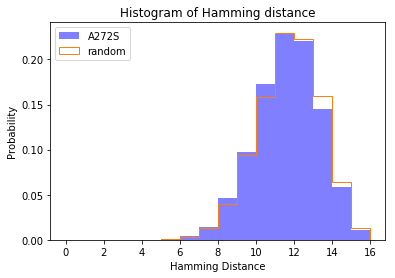

In [12]:
A272S_bc_subset = []
i = 0
while len(A272S_bc_subset) < 200:
    next_bc_group = A272S_hamm1_reduced[i]
    A272S_bc_subset.append(next_bc_group[0])
    i += 1

bases = ['A', 'T', 'C', 'G']
random_bc = []
while len(random_bc) < 200:
    new_bc_list = random.choices(bases, k = 15)
    new_bc = ''.join(new_bc_list)
    random_bc.append(new_bc)

A272S_hamming = []
for pair in list(itertools.combinations(A272S_bc_subset, 2)):
    A272S_hamming.append(hamming(pair[0], pair[1]))

random_hamming = []
for pair in list(itertools.combinations(random_bc, 2)):
    random_hamming.append(hamming(pair[0], pair[1]))

bins = range(17)

_, _, patch1 = plt.hist(A272S_hamming, bins, density=1, histtype = 'bar', facecolor='blue', 
                        alpha = 0.5, label = 'A272S')
_, _, patch2 = plt.hist(random_hamming, bins, density=1, histtype = 'step', facecolor='orange', label = 'random')
 
# add a 'best fit' line
plt.xlabel('Hamming Distance')
plt.ylabel('Probability')
plt.title('Histogram of Hamming distance')
plt.legend()

plt.show()

## Flattening and quality control
Now that we have the barcode groups, all that remains are a few quality control and processing steps. First we need to flatten the sublists in each barcode group (to remove the boundary between two barcodes within the same group) and remove barcode groups with only one read pair. Then we will concatenate the read 1 and read 2 sequences into one string, which will make them slightly easier to work with later. Then we will make sure that each sequence within a group is identical (more on this in a bit).

In [13]:
def combine_seqs(hamm1_reduced, barcode_groups):
######################################################################################
#                                                                                    #
# A housekeeping function that flattens the barcode groups into a list of sublists   # 
#   where each sublist contains the reads for one barcode group, removes barcode     #
#   groups that don't have at least two read pairs, and finally concatenates the     #
#   read pair into one string that contains both read 1 and read 2.                  #
#                                                                                    #
# Inputs:                                                                            #
#      hamm1_reduced: list of sublists where each sublist contains all of the tuples #
#        of read 1 and read 2 pairs that belong in one barcode group. If the barcode #
#        group has more than one barcode, the sublist will contain as many lists as  #
#        barcodes in the group.                                                      #
#      barcode_groups: dictionary with 15N barcode (type: str) as keys and           #
#        corresponding read pairs (type: tuple of strings) as values. Each key may   #
#        have multiple values.                                                       #
# Outputs:                                                                           #
#      seqs_concat: a list of sublists where each sublist contains all of the        #
#        sequences in a barcode group (list of flattened sublists of strings). Each  #
#        string corresponds to one read pair.                                        #
#                                                                                    #
######################################################################################

    seqs_groups = []
    for group in hamm1_reduced:
        seqs_hamm = []
        for i in range(len(group)):
            seqs_hamm.append(barcode_groups[group[i]])
        seqs_hamm_flat = [seq for sublist in seqs_hamm for seq in sublist]
        if len(seqs_hamm_flat) > 1:
            seqs_groups.append(seqs_hamm_flat)
    
    seqs_concat = []
    for group in seqs_groups:
        seqs_concat_grp = []
        for pair in group:
            seqs_concat_grp.append(pair[0] + pair[1])
        seqs_concat.append(seqs_concat_grp)
        
    return seqs_concat

In [14]:
A272S_seqs_concat = combine_seqs(A272S_hamm1_reduced, A272S_barcode_groups)
print(len(A272S_seqs_concat), "barcode groups with more than one read pair")

2629 barcode groups with more than one read pair


### Managing internal disagreement within barcode groups
So far we have created groups of reads that either came from the same barcode or came from barcodes that were only one base apart. We assume that each of these groups of reads corresponds to a single unique virus infecting a single cell, which should mean that all of the sequences within a barcode group are identical save for errors introduced in PCR. Note that this assumption only holds if there were the correct number of viruses added to the cells such that 

1. Each cell is only infected by one virus, and

2. No two viruses have the same barcode.

1 is mostly taken care of by the low MOI used to infect (actual MOI of ~0.03 ensures <1% multiple infection). 2 is trickier and it relies on the assumption that the library of viruses is sufficiently diverse to favor unique barcodes. My calculations indicated that around 57,000 unique transformants went into the maxiprep that produced the plasmid containing the barcode. Assuming that this complexity was preserved through maxiprep and transfection, at an MOI of 0.03 each well containing 1,500,000 cells was infected with 45,000 viruses. The number of times each barcode is drawn with 45,000 trials can be modeled with a multinomial distribution where the probability of each barcode being drawn is 1/57000. Let's model this in the code block below.

In [15]:
mv = np.random.multinomial(45000, [1/57000]*57000, 100)
total_viruses = np.sum(mv >= 1, 1)
total_multiples = np.sum(mv >= 2, 1)
percent_multiples = np.average(np.divide(total_multiples, total_viruses))
print(round(100*percent_multiples, 2), "% of all barcodes correspond to non-unique barcodes")

34.32 % of all barcodes correspond to non-unique barcodes


Evidently, this is probably going to be a problem. We don't want any non-unique barcodes, as this prohibits us from tracing each error to one integration event. The only obvious solution is to discard all groups where there is any disagreement between the sequences within the group. This will certainly take care of PCR errors, and it will also take care of any incidents where two viruses with the same barcode infect different cells and cause different errors or where one causes an error and one does not. The two cases that aren't covered here is if two viruses with the same barcode infect different cells and neither one causes an error or they both cause exactly the same error. The former seems far more likely than the latter. This is impossible to detect and correct for, and as a result the error rate calculations are likely to be skewed in favor of higher error rate.

Two different ways to correct this seem apparent. The first is obviously to re-make the library with at least tenfold higher complexity. The second, which is more of a band-aid solution, is to sequence longer reads, which would increase the probability of finding an in-group mismatch if a group contains reads from multiple infection events.

The next function discards groups with internal disagreement using the Hamming distance method.

In [16]:
def discard_internal_mm(seqs_concat):
######################################################################################
#                                                                                    #
# Checks to make sure that all sequences within a group are identical and saves      #
#   sequences from such valid groups.                                                #
#                                                                                    #
# Inputs:                                                                            #
#      seqs_concat: a list of sublists where each sublist contains all of the        #
#        sequences in a barcode group (list of flattened sublists of strings). Each  #
#        string corresponds to one read pair.                                        #
# Outputs:                                                                           #
#      true_seqs: a list of sequences where each sequence corresponds one-to-one     #
#        with a barcode group. List of strings.                                      #
#                                                                                    #
######################################################################################

    num_mismatched = 0
    true_seqs = []

    for group in seqs_concat:
        counter = 0
        combos = list(itertools.combinations(group, 2))

        for pair in combos:
            counter += hamming(pair[0], pair[1])

        if counter > 0:
            num_mismatched += 1
        else:
            true_seqs.append(group[0])

    return true_seqs

In [17]:
A272S_true_seqs = discard_internal_mm(A272S_seqs_concat)
print(len(A272S_seqs_concat) - len(A272S_true_seqs), "barcode groups with mismatches between reads")
print(len(A272S_true_seqs), "barcode groups without mismatches between reads")

644 barcode groups with mismatches between reads
1985 barcode groups without mismatches between reads


## Error rate calculation
Now we have sequences that theoretically correspond to single infection events. All that's left to calculate the error rate by comparing the sequences to eGFP.

In [18]:
eGFP_read1_fasta = SeqIO.read("eGFP_read1.fasta", "fasta")
eGFP_read1 = eGFP_read1_fasta.seq[0:112]

eGFP_read2_fasta = SeqIO.read("eGFP_read2.fasta", "fasta")
eGFP_read2 = eGFP_read2_fasta.seq[14:149]

eGFP = str(eGFP_read1) + str(eGFP_read2)

In [19]:
def calc_error_rate(true_seqs, reference):
######################################################################################
#                                                                                    #
# Finds errors between sequences and a reference and calculates the total error      #
#   rate.                                                                            #
#                                                                                    #
# Inputs:                                                                            #
#      true_seqs: a list of sequences where each sequence corresponds one-to-one     #
#        with a barcode group. List of strings.                                      #
#      reference: a string of the same length of each element of true_seqs           #
#        representing the reference sequence.                                        #
# Outputs:                                                                           #
#      bases_per_error: float representing the error rate in bases per error.        #
#                                                                                    #
######################################################################################

    nerror_list = []
    seqs_tested = 0
    for seq in true_seqs:
        errors = hamming(seq, reference)
        if errors <= 2:
            nerror_list.append(errors)
            seqs_tested += 1
        
    nerrors = sum(nerror_list)
    bases_tested = len(reference) * seqs_tested
    
    if sum(nerror_list) == 0:
        bases_per_error = float('nan')
    else:
        bases_per_error =  nerrors / bases_tested
    
    return bases_per_error, nerrors, bases_tested

In [20]:
A272S_error_rate, _, _ = calc_error_rate(A272S_true_seqs, eGFP)
print("Error rate: 1 error per", int(1/A272S_error_rate), "bases")

Error rate: 1 error per 122326 bases


## Calculation for all samples

In [21]:
barcode_numbers = {}
error_rates = {}

for sample, filepair in files.items():
    print("Calculating for sample", sample)
    s_barcodes, s_read1_seqs = read1_in(filepair[0])
    s_read2_seqs = read2_in(filepair[1])
    s_barcode_groups, s_unique_valid = find_barcode_groups(s_barcodes, s_read1_seqs, s_read2_seqs)
    
    s_hamm1_reduced = hamming_collapse(s_unique_valid)
    
    s_seqs_concat = combine_seqs(s_hamm1_reduced, s_barcode_groups)    
    s_true_seqs = discard_internal_mm(s_seqs_concat)
    
    s_error_rate, s_nerrors, s_bases_tested = calc_error_rate(s_true_seqs, eGFP)
    
    barcode_numbers[sample] = (len(s_unique_valid), len(s_hamm1_reduced), len(s_seqs_concat), len(s_true_seqs))
    error_rates[sample] = (s_error_rate, s_nerrors, s_bases_tested)

print("Done")

Calculating for sample Q151N
Calculating for sample M184I
Calculating for sample K65R
Calculating for sample neg
Calculating for sample A272S
Calculating for sample L74V
Calculating for sample Q151M
Calculating for sample M184V
Calculating for sample K70E
Calculating for sample L74I
Calculating for sample WT
Done


In [22]:
print(barcode_numbers)
print(error_rates)

{'Q151N': (307, 306, 5, 5), 'M184I': (710, 568, 141, 55), 'K65R': (1418, 1120, 732, 405), 'neg': (668, 430, 204, 47), 'A272S': (3600, 3297, 2629, 1985), 'L74V': (1678, 1349, 984, 499), 'Q151M': (2025, 1633, 1039, 542), 'M184V': (3215, 2896, 2314, 1664), 'K70E': (2091, 1904, 1400, 1026), 'L74I': (11108, 10952, 2745, 2463), 'WT': (3822, 3677, 1831, 1569)}
{'Q151N': (nan, 0, 1235), 'M184I': (7.36105999263894e-05, 1, 13585), 'K65R': (1.0021245039483705e-05, 1, 99788), 'neg': (nan, 0, 11609), 'A272S': (8.174826846948848e-06, 4, 489307), 'L74V': (nan, 0, 123006), 'Q151M': (nan, 0, 133627), 'M184V': (2.4389054192478418e-06, 1, 410020), 'K70E': (2.3722165991902834e-05, 6, 252928), 'L74I': (1.6471045549029361e-06, 1, 607126), 'WT': (1.2926510204187154e-05, 5, 386802)}
